In [35]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('processed_data.csv')

# Display the first few rows of the DataFrame to verify the data
df.head


<bound method NDFrame.head of         encounter_id  patient_nbr             race  gender       age  \
0            2278392      8222157        Caucasian  Female    [0-40)   
1             149190     55629189        Caucasian  Female    [0-40)   
2              64410     86047875  AfricanAmerican  Female    [0-40)   
3             500364     82442376        Caucasian    Male    [0-40)   
4              16680     42519267        Caucasian    Male   [40-50)   
...              ...          ...              ...     ...       ...   
101758     443847548    100162476  AfricanAmerican    Male   [70-80)   
101759     443847782     74694222  AfricanAmerican  Female  [80-100)   
101760     443854148     41088789        Caucasian    Male   [70-80)   
101761     443857166     31693671        Caucasian  Female  [80-100)   
101762     443867222    175429310        Caucasian    Male   [70-80)   

        admission_type_id discharge_disposition_id admission_source_id  \
0                       0      

In [36]:
import pandas as pd

def isKAnonymized(df):
    # Grouping DataFrame by race, gender, and age and counting the number of rows in each group
    group_counts = df.groupby(['race', 'gender', 'age']).size().reset_index(name='count')
    
    # Calculating the maximum value of k
    max_k = group_counts['count'].min()
    
    # Checking if any group has less than k rows
    if (group_counts['count'] < max_k).any():
        return False, max_k
    else:
        return True, max_k
    

In [37]:
isKAnonymized(df)


(True, 221)

In [38]:
import pandas as pd
from collections import Counter
import math

def calculate_entropy(values):
    """
    Calculate the entropy of a list of values.
    """
    value_counts = Counter(values)
    total_count = len(values)
    entropy = -sum((count / total_count) * math.log2(count / total_count) for count in value_counts.values() if count != 0)
    return entropy

def calculate_max_entropy(num_classes):
    """
    Calculate the maximum entropy given the number of unique classes,
    assuming a uniform distribution.
    """
    if num_classes <= 1:
        return 0  # If there's only one class or none, max entropy is zero
    return math.log2(num_classes)

def column_has_low_normalized_entropy(normalized_entropy, threshold=0.2):
    """
    Check if the normalized entropy is less than a specified threshold.
    
    Args:
        normalized_entropy (float): Normalized entropy value.
        threshold (float): Threshold below which entropy is considered low.
        
    Returns:
        bool: True if normalized entropy is below the threshold, otherwise False.
    """
    return normalized_entropy < threshold

def evaluate_diversity_by_equivalence_class(df, quasi_identifiers, normalized_entropy_threshold=0.2):
    """
    Group rows into equivalence classes based on quasi-identifiers and
    evaluate diversity for all non-quasi-identifier columns within each class.
    
    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        quasi_identifiers (list): Columns that define the equivalence classes.
        normalized_entropy_threshold (float): Threshold to identify columns with low normalized entropy.
    
    Returns:
        tuple: A tuple containing two DataFrames:
            1. A comprehensive report of all columns per equivalence class.
            2. A filtered report identifying only equivalence classes with low entropy columns.
    """
    # Ensure quasi-identifiers are in the DataFrame
    quasi_identifiers = [col for col in quasi_identifiers if col in df.columns]
    
    # Identify sensitive columns as those not in the quasi-identifiers
    sensitive_columns = [col for col in df.columns if col not in quasi_identifiers]

    if not sensitive_columns:
        print("No sensitive columns found.")
        return pd.DataFrame(), pd.DataFrame()

    # Group by quasi-identifiers to form equivalence classes
    grouped = df.groupby(quasi_identifiers)

    # Analyze diversity for the sensitive columns within each equivalence class
    diversity_data = []
    low_entropy_data = []
    for group_key, group_df in grouped:
        group_report = {
            'Equivalence Class': group_key,
            'Size': len(group_df)
        }
        
        for column in sensitive_columns:
            unique_values = group_df[column].unique()
            num_unique_values = len(unique_values)
            entropy = calculate_entropy(group_df[column])
            max_entropy = calculate_max_entropy(num_unique_values)
            normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
            has_low_normalized_entropy = column_has_low_normalized_entropy(normalized_entropy, normalized_entropy_threshold)
            
            group_report[f'{column} - Num Unique Values'] = num_unique_values
            group_report[f'{column} - Entropy'] = entropy
            group_report[f'{column} - Normalized Entropy'] = normalized_entropy
            group_report[f'{column} - Has Low Normalized Entropy (<0.2)'] = has_low_normalized_entropy
            
            # Track classes with low normalized entropy
            if has_low_normalized_entropy:
                low_entropy_data.append({
                    'Equivalence Class': group_key,
                    'Sensitive Column': column,
                    'Entropy': entropy,
                    'Normalized Entropy': normalized_entropy
                })
        
        diversity_data.append(group_report)
    
    # Convert to DataFrame for easier inspection
    diversity_report = pd.DataFrame(diversity_data)
    low_entropy_report = pd.DataFrame(low_entropy_data)
    
    return diversity_report, low_entropy_report


# Define quasi-identifiers
quasi_identifiers = ['age', 'gender', 'race']

# Evaluate diversity across non-quasi-identifier columns and identify low-entropy columns
diversity_report, low_entropy_report = evaluate_diversity_by_equivalence_class(df, quasi_identifiers, normalized_entropy_threshold=0.2)











Interpretation of Entropy
High Entropy: High entropy means the data is more diverse, and values are spread across many unique outcomes, meaning the distribution is more uniform or unpredictable.
Low Entropy: Low entropy indicates low diversity and more predictability, meaning most outcomes are concentrated in a few categories.

This normalized entropy will range between 0 and 1, helping you interpret the diversity more effectively across different equivalence classes and sensitive columns.

In [39]:
# Print the report and list of low entropy columns
print("\nDiversity Report:")
diversity_report




Diversity Report:


,Equivalence Class,Size,encounter_id - Num Unique Values,encounter_id - Entropy,encounter_id - Normalized Entropy,encounter_id - Has Low Normalized Entropy (<0.2),patient_nbr - Num Unique Values,patient_nbr - Entropy,patient_nbr - Normalized Entropy,patient_nbr - Has Low Normalized Entropy (<0.2),...,change - Normalized Entropy,change - Has Low Normalized Entropy (<0.2),diabetesMed - Num Unique Values,diabetesMed - Entropy,diabetesMed - Normalized Entropy,diabetesMed - Has Low Normalized Entropy (<0.2),readmitted - Num Unique Values,readmitted - Entropy,readmitted - Normalized Entropy,readmitted - Has Low Normalized Entropy (<0.2)
0,"([0-40), Female, AfricanAmerican)",1264,1264,10.303781,1.0,False,871,9.452901,0.967887,False,...,0.997526,False,2,0.715875,0.715875,False,2,0.492619,0.492619,False
1,"([0-40), Female, Caucasian)",2174,2174,11.086136,1.0,False,1547,10.202531,0.962934,False,...,0.984705,False,2,0.828656,0.828656,False,2,0.562938,0.562938,False
2,"([0-40), Female, other)",323,323,8.335390,1.0,False,262,7.835422,0.975353,False,...,0.999163,False,2,0.781824,0.781824,False,2,0.347041,0.347041,False
3,"([0-40), Male, AfricanAmerican)",724,724,9.499846,1.0,False,513,8.724828,0.969122,False,...,0.999449,False,2,0.657452,0.657452,False,2,0.529837,0.529837,False
4,"([0-40), Male, Caucasian)",1578,1578,10.623881,1.0,False,1142,9.843877,0.969139,False,...,0.998813,False,2,0.750612,0.750612,False,2,0.475391,0.475391,False
5,"([0-40), Male, other)",221,221,7.787903,1.0,False,191,7.459264,0.984406,False,...,0.993477,False,2,0.608139,0.608139,False,2,0.285435,0.285435,False
6,"([40-50), Female, AfricanAmerican)",1547,1547,10.595257,1.0,False,1058,9.708551,0.966302,False,...,0.996283,False,2,0.772552,0.772552,False,2,0.524436,0.524436,False
7,"([40-50), Female, Caucasian)",2927,2927,11.515207,1.0,False,2086,10.723075,0.972480,False,...,0.996926,False,2,0.834874,0.834874,False,2,0.482177,0.482177,False
8,"([40-50), Female, other)",337,337,8.396605,1.0,False,276,7.954659,0.981024,False,...,0.999841,False,2,0.775364,0.775364,False,2,0.359356,0.359356,False
9,"([40-50), Male, AfricanAmerican)",1240,1240,10.276124,1.0,False,840,9.365088,0.964057,False,...,0.999970,False,2,0.770629,0.770629,False,2,0.532136,0.532136,False


In [40]:
low_entropy_report

,Equivalence Class,Sensitive Column,Entropy,Normalized Entropy
0,"([0-40), Female, AfricanAmerican)",max_glu_serum,0.135542,0.067771
1,"([0-40), Female, AfricanAmerican)",repaglinide,0.033403,0.021075
2,"([0-40), Female, AfricanAmerican)",nateglinide,0.017002,0.017002
3,"([0-40), Female, AfricanAmerican)",chlorpropamide,-0.000000,0.000000
4,"([0-40), Female, AfricanAmerican)",glimepiride,0.140461,0.088621
...,...,...,...,...
619,"([80-100), Male, other)",glyburide-metformin,0.109031,0.109031
620,"([80-100), Male, other)",glipizide-metformin,-0.000000,0.000000
621,"([80-100), Male, other)",glimepiride-pioglitazone,-0.000000,0.000000
622,"([80-100), Male, other)",metformin-rosiglitazone,-0.000000,0.000000


In [41]:
# Ensure that the "Normalized Entropy" column exists in the low_entropy_report DataFrame
if "Normalized Entropy" in low_entropy_report.columns:
    # Find the row with the minimum value of "Normalized Entropy"
    min_row = low_entropy_report.loc[low_entropy_report["Normalized Entropy"].idxmin()]
    
    # Extract the column and equivalence class information
    min_normalized_entropy = min_row["Normalized Entropy"]
    sensitive_column = min_row["Sensitive Column"]
    equivalence_class = min_row["Equivalence Class"]
    
    # Display the information
    print(f"Minimum Normalized Entropy: {min_normalized_entropy}")
    print(f"Sensitive Column: {sensitive_column}")
    print(f"Equivalence Class: {equivalence_class}")
else:
    print("The 'Normalized Entropy' column was not found in the low_entropy_report.")



Minimum Normalized Entropy: 0.0
Sensitive Column: chlorpropamide
Equivalence Class: ('[0-40)', 'Female', 'AfricanAmerican')


In [42]:

output_path = "k221.csv"


df.to_csv(output_path, index=False)

Suppression

In [43]:
import pandas as pd

# Example DataFrame loading
# df = pd.read_csv('path_to_your_dataset.csv')

# Define your quasi-identifiers
quasi_identifiers = ['age', 'gender', 'race']  # Modify as per your dataset

# Function to enforce k-anonymity
def enforce_k_anonymity(df, quasi_identifiers, k):
    # Group by the quasi-identifiers
    grouped = df.groupby(quasi_identifiers).size().reset_index(name='count')
    
    # Filter groups that meet the k-anonymity requirement
    sufficient_anonymity = grouped[grouped['count'] >= k]
    
    # Merge back to the original dataframe to filter out rows that meet the k-anonymity
    df_anonymous = df.merge(sufficient_anonymity[quasi_identifiers], on=quasi_identifiers, how='inner')
    
    # Return the anonymized dataset
    return df_anonymous

# Calculate data loss
def calculate_data_loss(original_df, anonymous_df):
    original_count = len(original_df)
    anonymous_count = len(anonymous_df)
    lost_data = original_count - anonymous_count
    lost_percentage = (lost_data / original_count) * 100
    return lost_data, lost_percentage

# Apply the function to achieve k=300 anonymity
df_anonymous = enforce_k_anonymity(df, quasi_identifiers, 300)

# Calculate the data loss
lost_data, lost_percentage = calculate_data_loss(df, df_anonymous)

# Print data loss information
print(f"Original Dataset Size: {len(df)}")
print(f"Anonymized Dataset Size: {len(df_anonymous)}")
print(f"Data Lost: {lost_data} records")
print(f"Percentage of Data Lost: {lost_percentage:.2f}%")

# Save the modified dataset if needed
# df_anonymous.to_csv('path_to_your_anonymized_dataset.csv', index=False)

print("Anonymization complete. The dataset now satisfies k=300 anonymity.")



Original Dataset Size: 101763
Anonymized Dataset Size: 101542
Data Lost: 221 records
Percentage of Data Lost: 0.22%
Anonymization complete. The dataset now satisfies k=300 anonymity.


In [46]:
output_path = "k300.csv"


df_anonymous.to_csv(output_path, index=False)

In [47]:

df_anonymous1 = enforce_k_anonymity(df, quasi_identifiers, 500)


lost_data, lost_percentage = calculate_data_loss(df, df_anonymous)


print(f"Original Dataset Size: {len(df)}")
print(f"Anonymized Dataset Size: {len(df_anonymous)}")
print(f"Data Lost: {lost_data} records")
print(f"Percentage of Data Lost: {lost_percentage:.2f}%")

print("Anonymization complete. The dataset now satisfies k=500 anonymity.")

Original Dataset Size: 101763
Anonymized Dataset Size: 100106
Data Lost: 1657 records
Percentage of Data Lost: 1.63%
Anonymization complete. The dataset now satisfies k=500 anonymity.


In [48]:
output_path = "k500.csv"


df_anonymous1.to_csv(output_path, index=False)

In [49]:
df_anonymous2 = enforce_k_anonymity(df, quasi_identifiers, 800)


lost_data, lost_percentage = calculate_data_loss(df, df_anonymous)


print(f"Original Dataset Size: {len(df)}")
print(f"Anonymized Dataset Size: {len(df_anonymous)}")
print(f"Data Lost: {lost_data} records")
print(f"Percentage of Data Lost: {lost_percentage:.2f}%")

print("Anonymization complete. The dataset now satisfies k=800 anonymity.")

Original Dataset Size: 101763
Anonymized Dataset Size: 100106
Data Lost: 1657 records
Percentage of Data Lost: 1.63%
Anonymization complete. The dataset now satisfies k=800 anonymity.


In [50]:
output_path = "k800.csv"


df_anonymous2.to_csv(output_path, index=False)

In [51]:
df_anonymous3 = enforce_k_anonymity(df, quasi_identifiers, 1000)


lost_data, lost_percentage = calculate_data_loss(df, df_anonymous)


print(f"Original Dataset Size: {len(df)}")
print(f"Anonymized Dataset Size: {len(df_anonymous)}")
print(f"Data Lost: {lost_data} records")
print(f"Percentage of Data Lost: {lost_percentage:.2f}%")

print("Anonymization complete. The dataset now satisfies k=1000 anonymity.")

Original Dataset Size: 101763
Anonymized Dataset Size: 100106
Data Lost: 1657 records
Percentage of Data Lost: 1.63%
Anonymization complete. The dataset now satisfies k=1000 anonymity.


In [52]:
output_path = "k1000.csv"


df_anonymous3.to_csv(output_path, index=False)

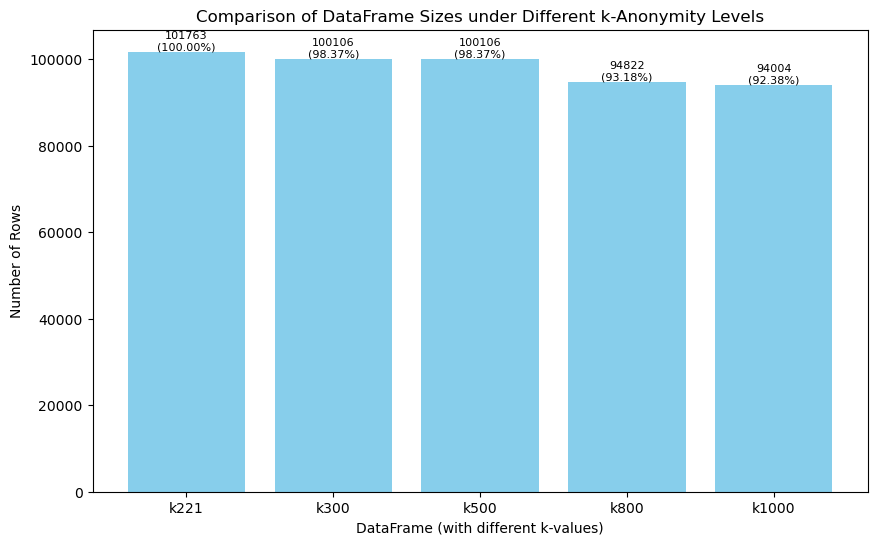

In [55]:

import matplotlib.pyplot as plt

# Assuming the list 'dataframes' and 'df_names' are already defined and populated as you described

# Calculate the size (number of rows) of each DataFrame
sizes = [len(df) for df in dataframes]

# Calculate the maximum size to determine percentages
max_size = max(sizes)
percentages = [(size / max_size) * 100 for size in sizes]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(df_names, sizes, color='skyblue')  # Create a bar chart

# Add number of rows and percentage labels to each bar
for bar, size, percentage in zip(bars, sizes, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{size}\n({percentage:.2f}%)', ha='center', va='bottom', fontsize=8)

plt.xlabel('DataFrame (with different k-values)')  # Label for the x-axis
plt.ylabel('Number of Rows')  # Label for the y-axis
plt.title('Comparison of DataFrame Sizes under Different k-Anonymity Levels')  # Title of the plot
plt.show()

